In [1]:
import glob
import requests
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import tensorflow as tf
import tensorflow.keras as tk
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Layer
from io import BytesIO
from PIL import Image

tf.keras.backend.set_floatx('float32')

In [ ]:
image_list = []
image_arrays = []
for filename in glob.glob('images/*'):
    im=Image.open(filename)
    image_list.append(im)
    image_arrays.append(np.array(im))

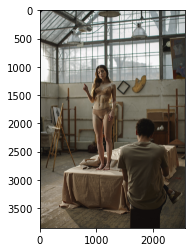

In [3]:
i = 7
img = image_arrays[i]
plt.imshow(img)
plt.show()

In [6]:
img2 = image_arrays[i]
img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2LAB)
img_org = img2.copy()
img2 = img2 / 255
img2 = img2.astype('float32')

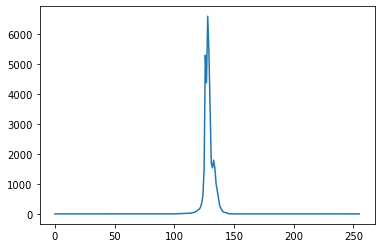

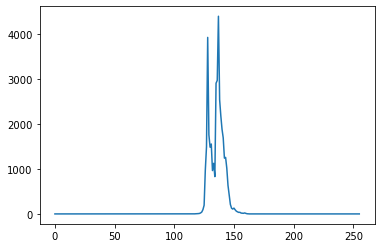

In [24]:
histr = cv2.calcHist([img_org],[1],None,[256],[0,256])
plt.plot(histr/256)
plt.show()
histr = cv2.calcHist([img_org],[2],None,[256],[0,256])
plt.plot(histr/256)
plt.show()

In [7]:
IMG_SHAPE = img2.shape
IMG_SHAPE

(3850, 2567, 3)

In [47]:
@tf.function
def adjust_color(img, alpha, channel):
    layer = img[:,:,channel]
    
    zeros = layer < alpha
    fs = tf.cast(alpha <= layer,tf.int8) * tf.cast(layer < 1 - alpha,tf.int8)
    ones = layer >= 1 - alpha
    
    img_proc_1 = tf.where(tf.cast(fs,tf.bool),tf.cast(1/(1-2*layer)*(layer - alpha),tf.float32),0.0)
    img_proc_2 = tf.where(ones,1.0,img_proc_1)
    img_proc = tf.stack([ img_proc_2 if i is channel else tf.cast(img[:,:,i],tf.float32) for i in range(3)],axis=2)
    return img_proc

@tf.function
def adjust_color_merge(img, alphas, alpha_factor, channel):
    return tf.foldl(
        lambda acc, alpha: acc + alpha[0] * adjust_color(img, alpha[1], channel),
        tf.stack([alphas[0],alpha_factor],axis=1),
        parallel_iterations=1,
        initializer=tf.zeros(img.shape)
    ) / alphas.shape[1]

In [48]:
class AdjustColor(Layer):

    def __init__(self, channel, trainable=True, **kwargs):
        super(AdjustColor, self).__init__(**kwargs)
        self.supports_masking = True
        self.alpha = tf.random.normal([2048])
        self.trainable = trainable
        self.channel = channel

    def build(self, input_shape):
               
        self.alpha_factor = tf.Variable(self.alpha,
                                      shape=(2048),
                                      dtype='float32',
                                      name='alpha_factor')
        if self.trainable:
            self._trainable_weights.append(self.alpha_factor)

        super(AdjustColor, self).build(input_shape)

    def call(self, images, features, mask=None):
        return tf.map_fn(lambda img: adjust_color_merge(img, features, self.alpha_factor, self.channel),
                         images,
                         swap_memory=True,
                         parallel_iterations=1
                        )

In [49]:
conv_feature_extractor = tf.keras.applications.ResNet50(input_shape=(512,512,3),include_top=False)
conv_feature_extractor.trainable=False

G_inputs = tk.Input(shape=IMG_SHAPE)
x = tf.image.resize(G_inputs,(512,512))
x = conv_feature_extractor(x)
features = tk.layers.GlobalMaxPool2D()(x)
y = AdjustColor(channel=1)(G_inputs,features)
z = AdjustColor(channel=2)(G_inputs,features)
out = tf.stack([G_inputs[:,:,:,0],y[:,:,:,1],z[:,:,:,2]],axis=3)

G_model = tk.Model(inputs=G_inputs,
                   outputs=out,
                   name="G")
G_model.summary()

Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 3850, 2567,  0                                            
__________________________________________________________________________________________________
tf_op_layer_resize_5/ResizeBili [(None, 512, 512, 3) 0           input_12[0][0]                   
__________________________________________________________________________________________________
resnet50 (Model)                (None, 16, 16, 2048) 23587712    tf_op_layer_resize_5/ResizeBiline
__________________________________________________________________________________________________
global_max_pooling2d_5 (GlobalM (None, 2048)         0           resnet50[1][0]                   
__________________________________________________________________________________________________

In [50]:
G_model.compile('adam','binary_crossentropy')

In [51]:
out_images = G_model.predict(np.array([img2]*4).reshape(-1,*img2.shape))

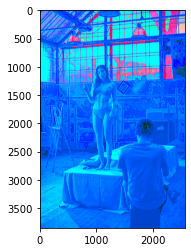

In [54]:
img3 = tf.cast(out_images[0] * 255,tf.uint8).numpy()
out = cv2.cvtColor(img3, cv2.COLOR_LAB2RGB)
plt.imshow(out)
plt.show()

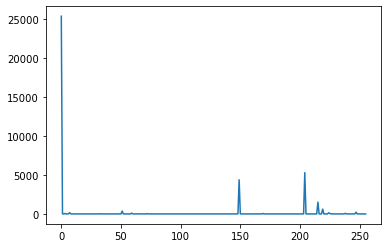

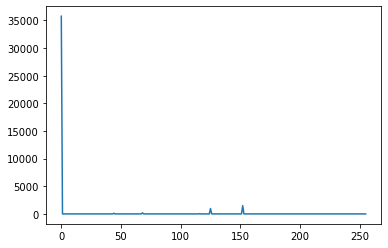

In [55]:
histr = cv2.calcHist([img3],[1],None,[256],[0,256])
plt.plot(histr/256)
plt.show()
histr = cv2.calcHist([img3],[2],None,[256],[0,256])
plt.plot(histr/256)
plt.show()

In [ ]:
1/0

In [ ]:
# Generator
G_inputs = tk.Input(shape=(100,), name=f"G_inputs")

x = tk.layers.Dense(7 * 7 * 16)(G_inputs)
x = tf.nn.leaky_relu(x)
x = tk.layers.Flatten()(x)
x = tk.layers.Reshape((7, 7, 16))(x)

x = tk.layers.Conv2DTranspose(32, (3, 3), padding="same")(x)
x = tk.layers.BatchNormalization()(x)
x = tf.nn.leaky_relu(x)
x = tf.image.resize(x, (14, 14))

x = tk.layers.Conv2DTranspose(32, (3, 3), padding="same")(x)
x = tk.layers.BatchNormalization()(x)
x = tf.nn.leaky_relu(x)
x = tf.image.resize(x, (28, 28))

x = tk.layers.Conv2DTranspose(32, (3, 3), padding="same")(x)
x = tk.layers.BatchNormalization()(x)
x = tf.nn.leaky_relu(x)

x = tk.layers.Conv2DTranspose(1, (3, 3), padding="same")(x)
x = tf.nn.sigmoid(x)

G_model = tk.Model(inputs=G_inputs,
                   outputs=x,
                   name="G")
G_model.summary()

# Discriminator
D_inputs = tk.Input(shape=(28, 28, 1), name=f"D_inputs")

x = tk.layers.Conv2D(32, (3, 3), padding="same")(D_inputs)
x = tf.nn.leaky_relu(x)
x = tk.layers.MaxPooling2D((2, 2))(x)
x = tk.layers.Conv2D(32, (3, 3), padding="same")(x)
x = tf.nn.leaky_relu(x)
x = tk.layers.MaxPooling2D((2, 2))(x)
x = tk.layers.Conv2D(64, (3, 3), padding="same")(x)
x = tf.nn.leaky_relu(x)

x = tk.layers.Flatten()(x)

x = tk.layers.Dense(128)(x)
x = tf.nn.sigmoid(x)
x = tk.layers.Dense(64)(x)
x = tf.nn.sigmoid(x)
x = tk.layers.Dense(1)(x)
x = tf.nn.sigmoid(x)

D_model = tk.Model(inputs=D_inputs,
                   outputs=x,
                   name="D")

D_model.compile(optimizer=tk.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, name="Adam_D"),
                loss="binary_crossentropy")
D_model.summary()

GAN = tk.Sequential()
GAN.add(G_model)
GAN.add(D_model)
GAN.compile(optimizer=tk.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, name="Adam_GAN"),
            loss="binary_crossentropy")

tb = tk.callbacks.TensorBoard(log_dir="./tb_tf2.0", write_graph=True)

# dummy data
noise = np.random.rand(100, 100).astype(np.float32)
target = np.ones(shape=(100, 1), dtype=np.float32)

GAN.fit(x=noise,
        y=target,
        callbacks=[tb])